In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional, Input, Dot, Activation, Concatenate, Permute, Flatten, RepeatVector, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error

Model saved to 'attention_lstm_model_returns.h5'


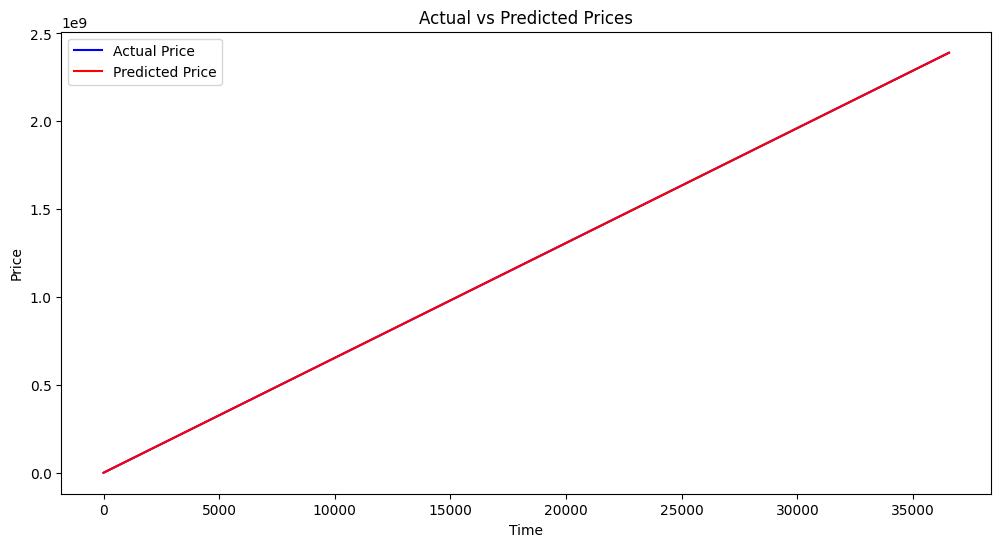

In [39]:
# Define the initial price (e.g., the closing price before the start of the prediction period)
initial_price = df.iloc[split - 1]['Close']

# Calculate the cumulative sum of actual and predicted returns
actual_cumulative_returns = np.cumsum(y_test_inv)
predicted_cumulative_returns = np.cumsum(y_pred_inv)

# Add 1 to the cumulative return series to get the multiplier for price growth
actual_price_multiplier = 1 + actual_cumulative_returns
predicted_price_multiplier = 1 + predicted_cumulative_returns

# Multiply the multiplier series by the initial price to get the predicted price series
actual_prices = initial_price * actual_price_multiplier
predicted_prices = initial_price * predicted_price_multiplier

# Plot actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price', color='blue')
plt.plot(predicted_prices, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [40]:
def naive_forecast(data):
    return data[:-1]  # Predictions are the same as the last observed values

naive_scaler = StandardScaler()
y_naive_pred = naive_forecast(y_test)
# Fit the scaler on the actual test data
naive_scaler.fit(y_test.reshape(-1, 1))

# Scale naive forecast predictions and actual test data using the new scaler
y_naive_pred_scaled = naive_scaler.transform(y_naive_pred.reshape(-1, 1)).flatten()
y_test_scaled = naive_scaler.transform(y_test.reshape(-1, 1)).flatten()

# Compute naive forecast MAE on scaled values
naive_mae_scaled = mean_absolute_error(y_test_scaled[1:], y_naive_pred_scaled)

# Inverse transform the MAE to the original scale for minmax
#naive_mae = naive_mae_scaled * (naive_scaler.data_max_[0] - naive_scaler.data_min_[0])

naive_mae = naive_mae_scaled * naive_scaler.scale_[0]

print("Naive Forecast MAE (Original Scale):", naive_mae)

Naive Forecast MAE (Original Scale): 0.9737056296588539


In [44]:
class myLSTM:
    def __init__(self,path=r'D:\binanceapi\MarketData\BTCUSDT\BTCUSDT_1m.csv'):
        # Load your dataset
        self.df = pd.read_csv(path)
        # Convert timestamps if necessary
        self.df['Open Time'] = pd.to_datetime(self.df['Open Time'])
        self.df['Close Time'] = pd.to_datetime(self.df['Close Time'])
        # Drop or convert the timestamp columns since LSTM cannot process datetime directly
        self.df = self.df.drop(['Open Time', 'Close Time'], axis=1)
        # Compute returns
        self.df['Returns'] = (self.df['Close'] / self.df['Close'].shift(1))
        self.df = self.df.drop(["Close","High","Low","Open"],axis=1)
        # Drop the first row with NaN return value
        self.df = self.df.dropna()

        # Feature scaling
        self.X_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
        self.scaled_y = self.y_scaler.fit_transform(self.df["Returns"].values.reshape(-1,1))
        self.df = self.df.drop(["Returns"],axis = 1)
        self.scaled_X = self.X_scaler.fit_transform(self.df)

    # Prepare the data for LSTM
    def create_dataset(self, n_steps=60):
        self.step_size = n_steps
        X, y = [], []
        for i in range(self.scaled_X.shape[0] - n_steps):
            X.append(self.scaled_X[i:i + n_steps])
            y.append(self.scaled_y[i + n_steps])  # Assuming 'Returns' is the last column

        self.preprocessed_X = X
        self.preprocessed_y = y
    
    def train_test_split(self,split_ratio = 0.8):
        # Train-test split
        split = int(self.scaled_X.shape[0] * split_ratio)
        self.X_train, self.X_test = self.preprocessed_X[:split], self.preprocessed_X[split:]
        self.y_train, self.y_test = self.preprocessed_y[:split], self.preprocessed_y[split:]
    
    # Define the model with attention mechanism
    def build_model(self):
        inputs = Input(shape=(self.n_steps, self.X_train.shape[2]))
        lstm_out1 = Bidirectional(LSTM(100))(inputs)
        output = Dense(1)(lstm_out1)
        model = Model(inputs=inputs, outputs=output)
        model.compile(optimizer='adam', loss='mean_absolute_error')
        self.model = model
    
    def train(self,epoch_in = 10,batch_size_in=32,validation_split_in=0.2):
        # Early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        # Train the model
        self.history = model.fit(X_train, y_train, epochs=epochs_in, batch_size=batch_size_in, validation_split=validation_split_in, callbacks=[early_stopping])
    
    def generate_inverse(self):
        y_pred = self.model.predict(self.X_test)
        # Inverse transform the predictions and actual values to original scale
        y_test_inv = (self.y_test * self.y_scaler.var_) + self.y_scaler.mean_ 
        self.y_pred_inv = (y_pred * self.y_scaler.var_) + self.y_scaler.mean_ 
        self.y_test_inv = y_test_inv.reshape(-1,1)
    
    def plot_returns(self):
        # Ensure both arrays have the same shape
        assert y_test_inv.shape == y_pred_inv.shape, "Shapes of y_test_inv and y_pred_inv don't match"

        # Plot actual vs predicted returns
        plt.figure(figsize=(12, 6))
        plt.plot(self.y_test_inv, label='Actual Returns')
        plt.plot(self.y_pred_inv, label='Predicted Returns')
        plt.title('Actual vs Predicted Returns with Attention Mechanism')
        plt.xlabel('Time')
        plt.ylabel('Returns')
        plt.legend()
        plt.show()
        # Compute and print mean absolute error (MAE)
        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        self.mae_score = mae
        print("Mean Absolute Error (MAE):", mae)

In [45]:
mLstm = myLSTM()
mLstm.create_dataset()
mLstm.train_test_split()

NameError: name 'X' is not defined